# Test 2

1) Assume, you ran a classification exercise and you determined the
accuracy over training set to be TE, and the accuracy on test set to be ET. Under what condition

will you use boosting to improve the performance?

will you use bagging to improve the performance? 40 minutes


2) How is bagging different from cross validation? 20 minutes


3) Repeat bagging and CV over heart, ecoli, and icu datasets and generate
a performance (accuracy, AUC) matrix by class. (4 Hours)

## Question 1

The Bagging and Boosting ensemble methods fixes different problems of the same domain. Imagine We have a model, that has very high accuracy on the training dataset, but fitting the data, it was not trained on returns poor accuracy. Verdict: model is overfitted, so it has very high variance. Overfitting can happen because of fitting a lot of features, that have no significant impact on the resulting value. So the model finds some random patterns in this data, that actually are just noise and define no tendency. In this case We should use Bagging. It is useful for unstable models. It splits dataset into m subsets of n observations with repetitions (so one observation can happen more than once in one sample), fits m different models and estimates their accuracy on the same testing dataset. This process repeats a few times and as a result, bagging returns the best model.

Another scenario is when we fit a model, that has low both TE and ET. Perhaps we chose not enough features, or we use highly linear model, such as OLS on non-linear data. In this case we should use Boosting. It will also train m models, but the difference is every wrongly predicted observation will be fitted again and again. After the process, method chooses the best model and returns it.

## Question 2

First of all Bagging is an ensemble model, that can apply changes on your model (particularly decreasing variance, preventing overfitting). We use it when improving flexible models.

Cross validation is kind of evaluation method, that can be useful while fitting small datasets, or in case ob absence testing data. You can split dataset into training and testing samples with relation 80% to 20%, but it does not guarantee, that all the outliers didn't happen to be in testing sample. In this case test error will be huge. As an example I can provide data from our Test 1. We got only 36 observations and a lot of outliers, so changing the seed could have cause decreasing of accuracy up to 30%.

So cross validation is just shuffling the training and testing data samples and provides insights about goodness of fit. While Bagging is a technique that improves the model.

## Question 3

### Heart Data

In [154]:
library(mltest)
library(dplyr)  
library(e1071)   
library(caret)     
library(rpart)       
library(ipred)       
library(tidyverse)
library(Metrics)
library(ggplot2)
library(cvms)
library(ggcorrplot)
library(GGally)
library(pROC)

In [155]:
heart <- read.csv("data/heart.csv")
ecoli <- read.csv("data/ecoli.csv")
options(warn=-1)

In [156]:
head(heart)
heart$target <- as.factor(heart$target)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
6,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


In [157]:
set.seed(1)
sample <- sample(c(TRUE, FALSE), nrow(heart), replace=TRUE, prob=c(0.8,0.2))
train <- heart[sample, ]
test <- heart[!sample, ]

test.X <- test[1:13]
test.Y <- test[14]

train.X<-train[1:13]
train.Y<-train[14]

In [158]:
logit.fit <- glm(train$target ~ ., data=train, family = binomial)

logit.train <- predict(logit.fit, train.X, type="response")
logit.train <- ifelse(test=logit.train>0.5, yes=1, no=0)

logit.pred <- predict(logit.fit, test.X, type="response")
logit.pred <- ifelse(test=logit.pred>0.5, yes=1, no=0)

message("Train Error is ", round(mean(logit.train != train.Y$target),2)*100, "%")
message("Test Error is ", round(mean(logit.pred != test.Y$target),2)*100, "%")

Train Error is 13%

Test Error is 27%



Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test.Y$target, predictor = logit.pred,     plot = TRUE)

Data: logit.pred in 23 controls (test.Y$target 0) < 26 cases (test.Y$target 1).
Area under the curve: 0.7299

Setting levels: control = 0, case = 1

Setting direction: controls < cases

AUC: 0.729933110367893



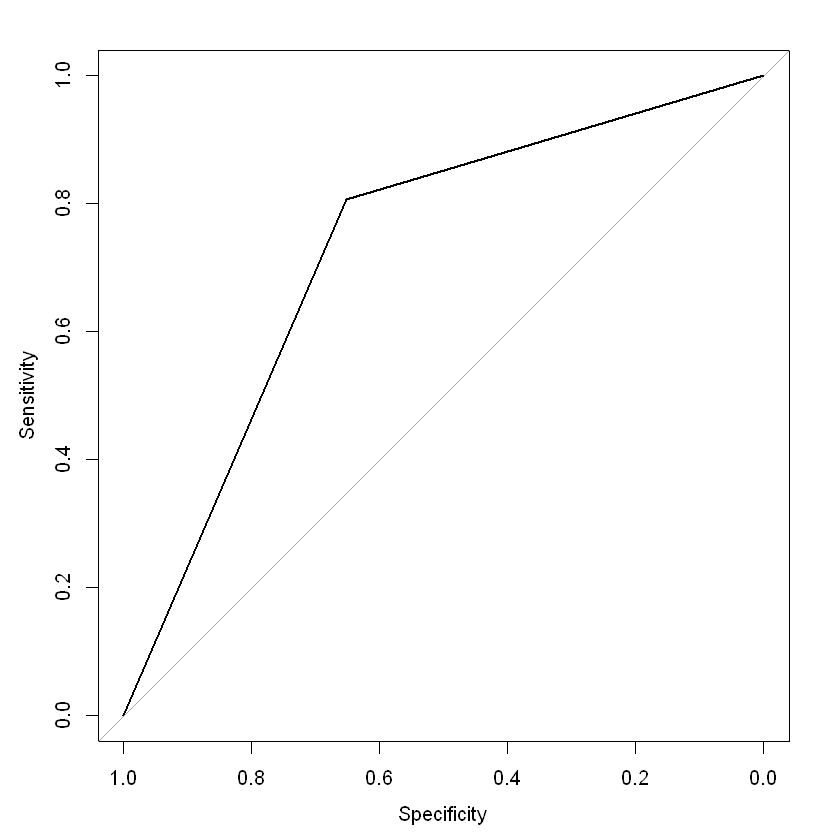

In [159]:
roc(test.Y$target, logit.pred, plot=TRUE)
message("AUC: ", auc(test.Y$target, logit.pred))

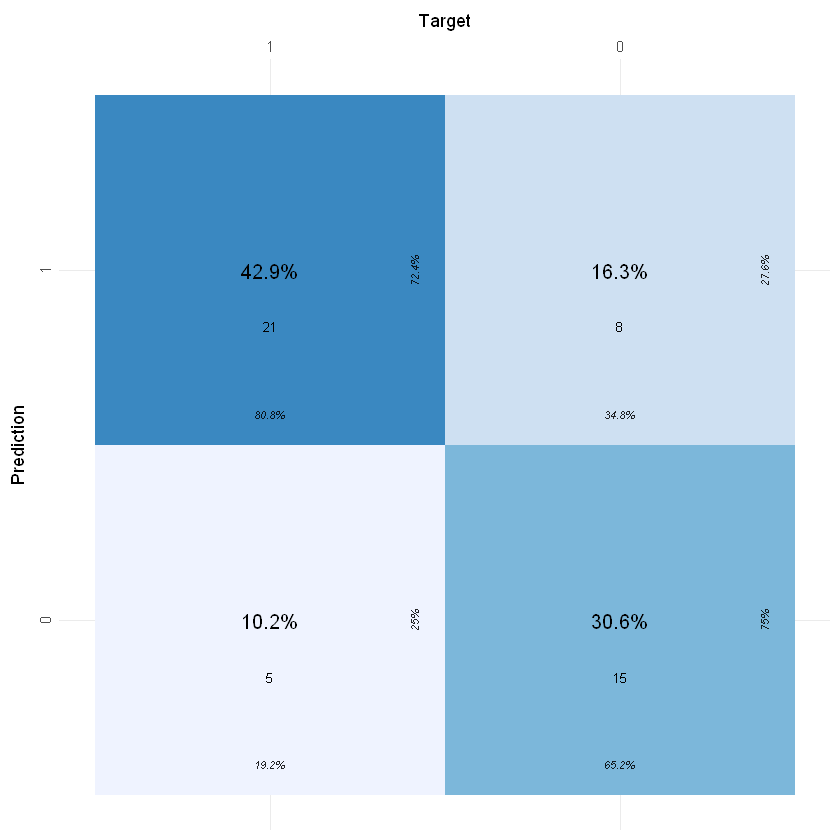

In [160]:
plot_confusion_matrix(confusion_matrix(test.Y$target, logit.pred))

In [161]:
bag.fit <- bagging(formula = target ~ ., data = train, nbagg = 160, coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)

bag.pred <- predict(bag.fit, newdata = test.X)

,var,Overall
,<chr>,<dbl>
oldpeak,thalach,59.299643
thalach,thal,56.635545
cp,chol,53.686558
ca,cp,52.204492
thal,ca,43.421150
exang,fbs,42.446108
age,sex,32.725445
trestbps,target,30.041658
chol,trestbps,26.762765


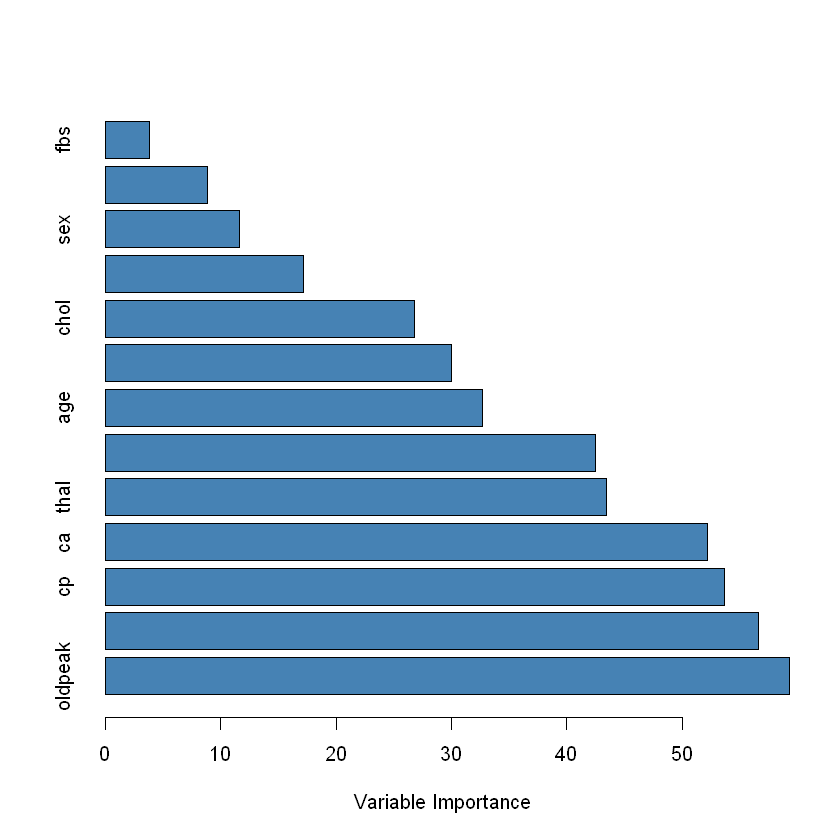

In [162]:
VI <- data.frame(var=names(heart[,-1]), imp=varImp(bag.fit))
VI_plot <- VI[order(VI$Overall, decreasing=TRUE),]
VI_plot
barplot(VI_plot$Overall,
        names.arg=rownames(VI_plot),
        horiz=TRUE,
        col='steelblue',
        xlab='Variable Importance')

In [163]:
heart <- heart[,c("target", "oldpeak", "thalach", "cp", "ca", "thal", "exang")]
sample <- sample(c(TRUE, FALSE), nrow(heart), replace=TRUE, prob=c(0.8,0.2))
train <- heart[sample, ]
test <- heart[!sample, ]

test.X <- test[2:7]
test.Y <- test[1]

train.X<-train[2:7]
train.Y<-train[1]

In [164]:
logit.fit <- glm(train$target ~ ., data=train, family = binomial)

logit.train <- predict(logit.fit, train.X, type="response")
logit.train <- ifelse(test=logit.train>0.5, yes=1, no=0)

logit.pred <- predict(logit.fit, test.X, type="response")
logit.pred <- ifelse(test=logit.pred>0.5, yes=1, no=0)

message("Train Error is ", round(mean(logit.train != train.Y$target),2)*100, "%")
message("Test Error is ", round(mean(logit.pred != test.Y$target),2)*100, "%")

Train Error is 16%

Test Error is 10%



Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test.Y$target, predictor = logit.pred,     plot = TRUE)

Data: logit.pred in 35 controls (test.Y$target 0) < 32 cases (test.Y$target 1).
Area under the curve: 0.9

Setting levels: control = 0, case = 1

Setting direction: controls < cases

AUC: 0.9



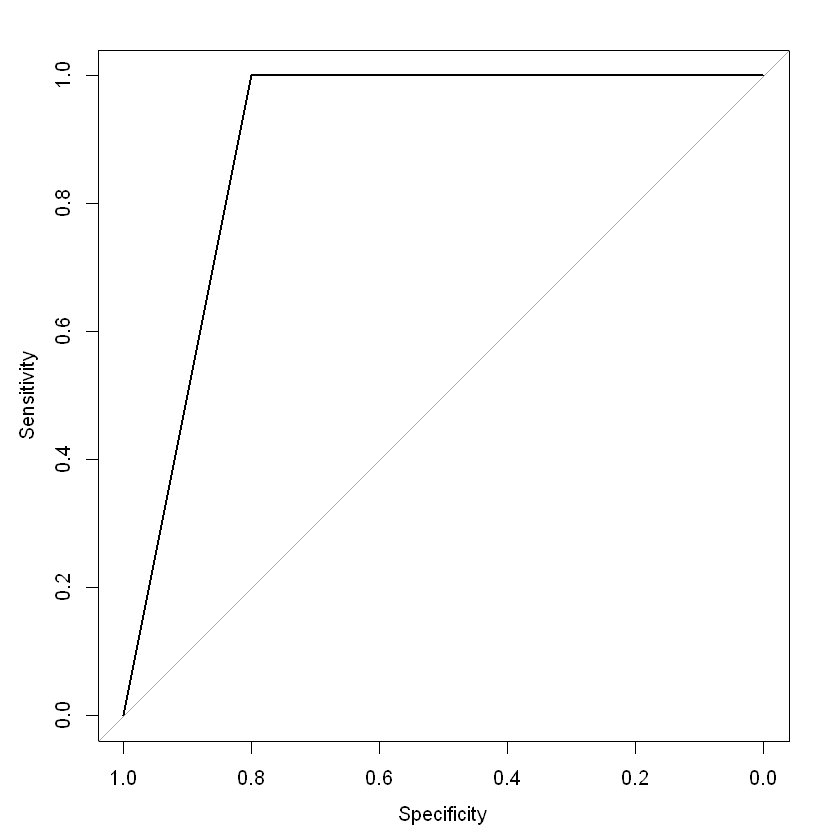

In [165]:
roc(test.Y$target, logit.pred, plot=TRUE)
message("AUC: ", auc(test.Y$target, logit.pred))

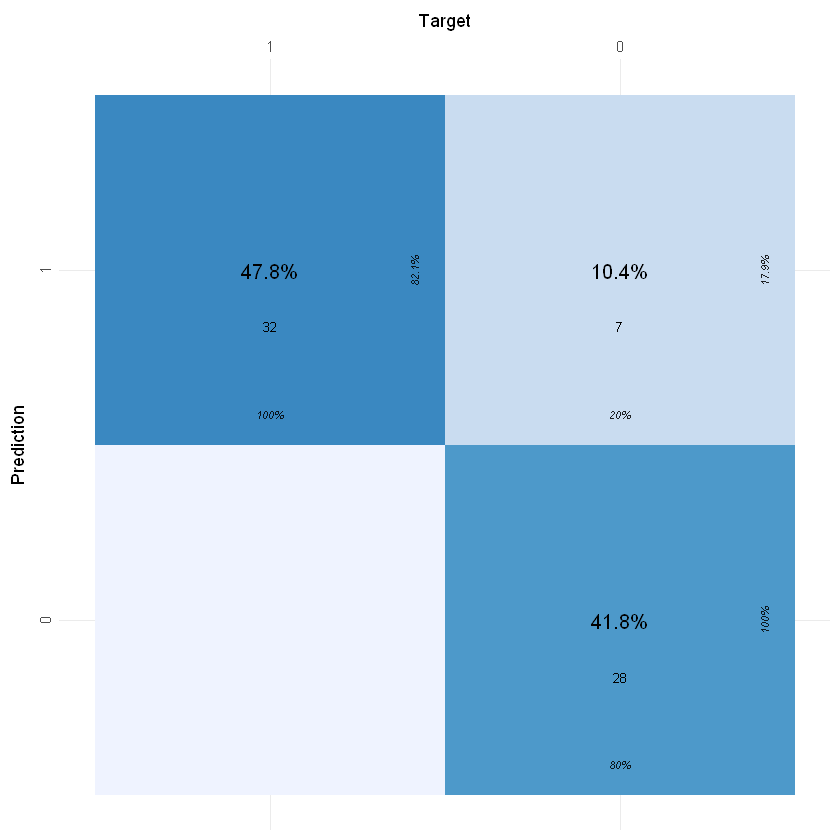

In [166]:
plot_confusion_matrix(confusion_matrix(test.Y$target, logit.pred))

### Ecoli Data

In [167]:
head(ecoli)

,mcg,gvh,lip,chg,aac,alm1,alm2,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp


In [168]:
unique(ecoli$class)

[1] "cp"  "im"  "imS" "imL" "imU" "om"  "omL" "pp"

Unfortunately I don't have time for this dataset, especially plotting every ROC curve. I'm really sorry.

### Icu Data

In [169]:
icu <- read.csv("data/icu.csv")
head(icu)

,ID,STA,AGE,SEX,RACE,SER,CAN,CRN,INF,CPR,⋯,HRA,PRE,TYP,FRA,PO2,PH,PCO,BIC,CRE,LOC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,8,0,27,1,1,0,0,0,1,0,⋯,88,0,1,0,0,0,0,0,0,0
2,12,0,59,0,1,0,0,0,0,0,⋯,80,1,1,0,0,0,0,0,0,0
3,14,0,77,0,1,1,0,0,0,0,⋯,70,0,0,0,0,0,0,0,0,0
4,28,0,54,0,1,0,0,0,1,0,⋯,103,0,1,1,0,0,0,0,0,0
5,32,0,87,1,1,1,0,0,1,0,⋯,154,1,1,0,0,0,0,0,0,0
6,38,0,69,0,1,0,0,0,1,0,⋯,132,0,1,0,1,0,0,1,0,0


In [170]:
summary(icu)

       ID             STA           AGE             SEX            RACE      
 Min.   :  4.0   Min.   :0.0   Min.   :16.00   Min.   :0.00   Min.   :1.000  
 1st Qu.:210.2   1st Qu.:0.0   1st Qu.:46.75   1st Qu.:0.00   1st Qu.:1.000  
 Median :412.5   Median :0.0   Median :63.00   Median :0.00   Median :1.000  
 Mean   :444.8   Mean   :0.2   Mean   :57.55   Mean   :0.38   Mean   :1.175  
 3rd Qu.:671.8   3rd Qu.:0.0   3rd Qu.:72.00   3rd Qu.:1.00   3rd Qu.:1.000  
 Max.   :929.0   Max.   :1.0   Max.   :92.00   Max.   :1.00   Max.   :3.000  
      SER             CAN           CRN             INF            CPR       
 Min.   :0.000   Min.   :0.0   Min.   :0.000   Min.   :0.00   Min.   :0.000  
 1st Qu.:0.000   1st Qu.:0.0   1st Qu.:0.000   1st Qu.:0.00   1st Qu.:0.000  
 Median :1.000   Median :0.0   Median :0.000   Median :0.00   Median :0.000  
 Mean   :0.535   Mean   :0.1   Mean   :0.095   Mean   :0.42   Mean   :0.065  
 3rd Qu.:1.000   3rd Qu.:0.0   3rd Qu.:0.000   3rd Qu.:1.00   3r

In [171]:
icu$STA <- as.factor(icu$STA)
icu$SEX <- as.factor(icu$SEX)
icu$RACE <- as.factor(icu$RACE)
icu$SER <- as.factor(icu$SER)
icu$CAN <- as.factor(icu$CAN)
icu$CRN <- as.factor(icu$CRN)
icu$INF <- as.factor(icu$INF)
icu$CPR <- as.factor(icu$CPR)
icu$PRE <- as.factor(icu$PRE)
icu$TYP <- as.factor(icu$TYP)
icu$FRA <- as.factor(icu$FRA)
icu$PO2 <- as.factor(icu$PO2)
icu$PH <- as.factor(icu$PH)
icu$PCO <- as.factor(icu$PCO)
icu$BIC <- as.factor(icu$BIC)
icu$CRE <- as.factor(icu$CRE)
icu$LOC <- as.factor(icu$LOC)

In [172]:
set.seed(4)
sample <- sample(c(TRUE, FALSE), nrow(icu), replace=TRUE, prob=c(0.8,0.2))
train <- icu[sample, ]
test <- icu[!sample, ]

test.X <- select(test, -STA)
test.Y <- test[2]

train.X<-select(train, -STA)
train.Y<-train[2]

In [173]:
logit.fit <- glm(train$STA ~ ., data=train, family = binomial)

logit.train <- predict(logit.fit, train.X, type="response")
logit.train <- ifelse(test=logit.train>0.5, yes=1, no=0)

logit.pred <- predict(logit.fit, test.X, type="response")
logit.pred <- ifelse(test=logit.pred>0.5, yes=1, no=0)

message("Train Error is ", round(mean(logit.train != train.Y$STA),2)*100, "%")
message("Test Error is ", round(mean(logit.pred != test.Y$STA),2)*100, "%")

Train Error is 14%

Test Error is 21%



Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test.Y$STA, predictor = logit.pred, plot = TRUE)

Data: logit.pred in 40 controls (test.Y$STA 0) < 7 cases (test.Y$STA 1).
Area under the curve: 0.6982

Setting levels: control = 0, case = 1

Setting direction: controls < cases

AUC: 0.698214285714286



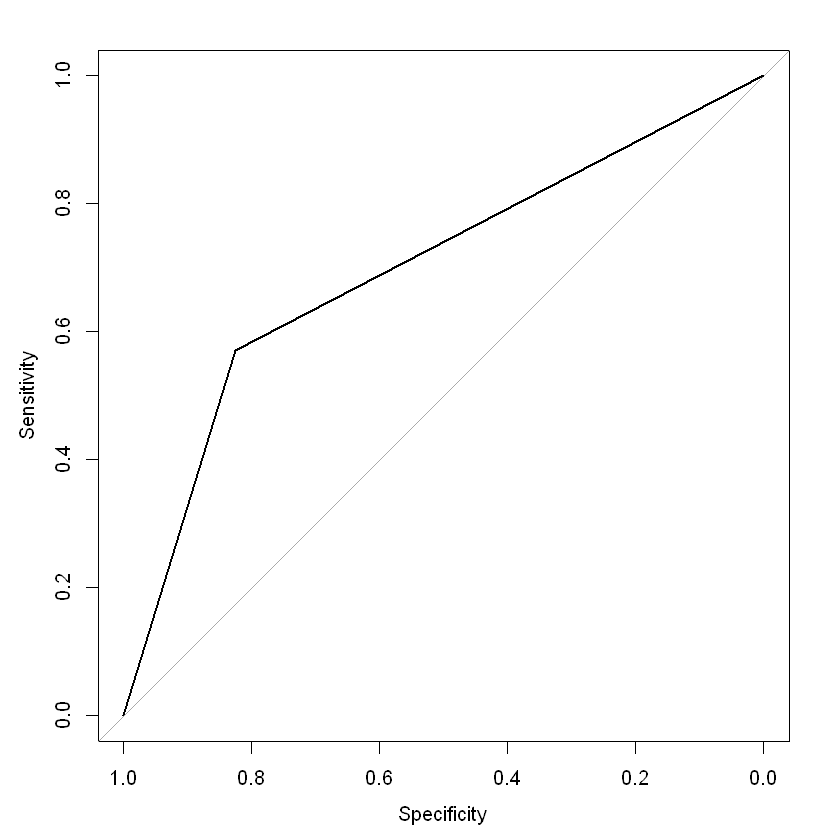

In [174]:
roc(test.Y$STA, logit.pred, plot=TRUE)
message("AUC: ", auc(test.Y$STA, logit.pred))

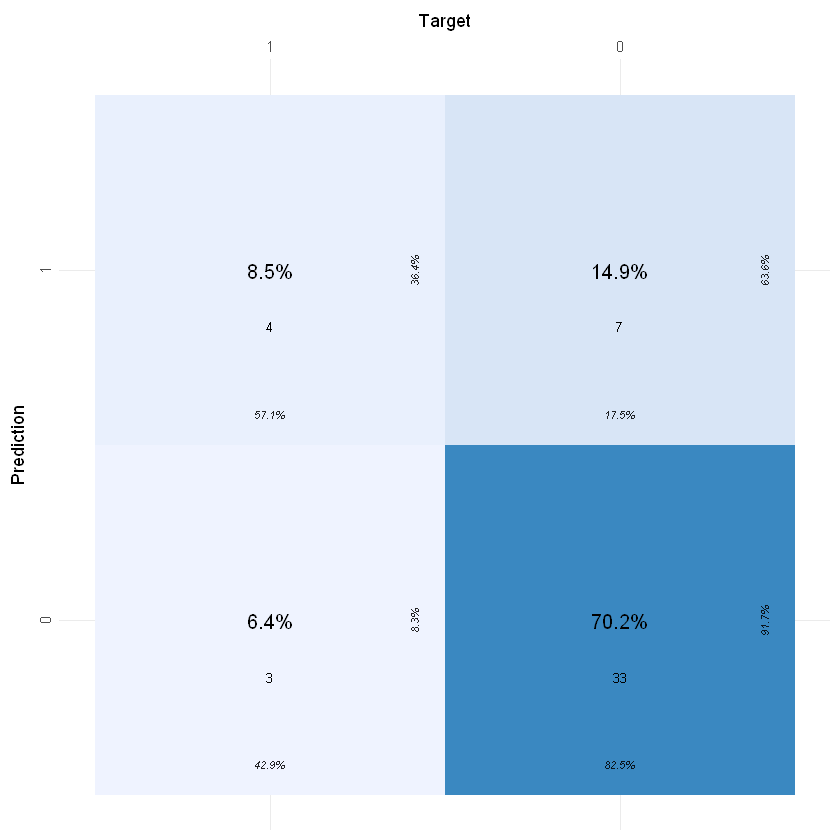

In [175]:
plot_confusion_matrix(confusion_matrix(test.Y$STA, logit.pred))

In [176]:
bag.fit <- bagging(formula = STA ~ ., data = train, nbagg = 160, coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)

bag.pred <- predict(bag.fit, newdata = test.X)

,var,Overall
,<chr>,<dbl>
ID,CPR,25.7476454
SYS,CRE,24.5015218
AGE,STA,22.3588908
HRA,INF,17.5158010
LOC,HRA,13.7341788
TYP,LOC,8.8356303
CRN,CAN,6.9789915
SER,PCO,6.5927578
SEX,BIC,4.1431219


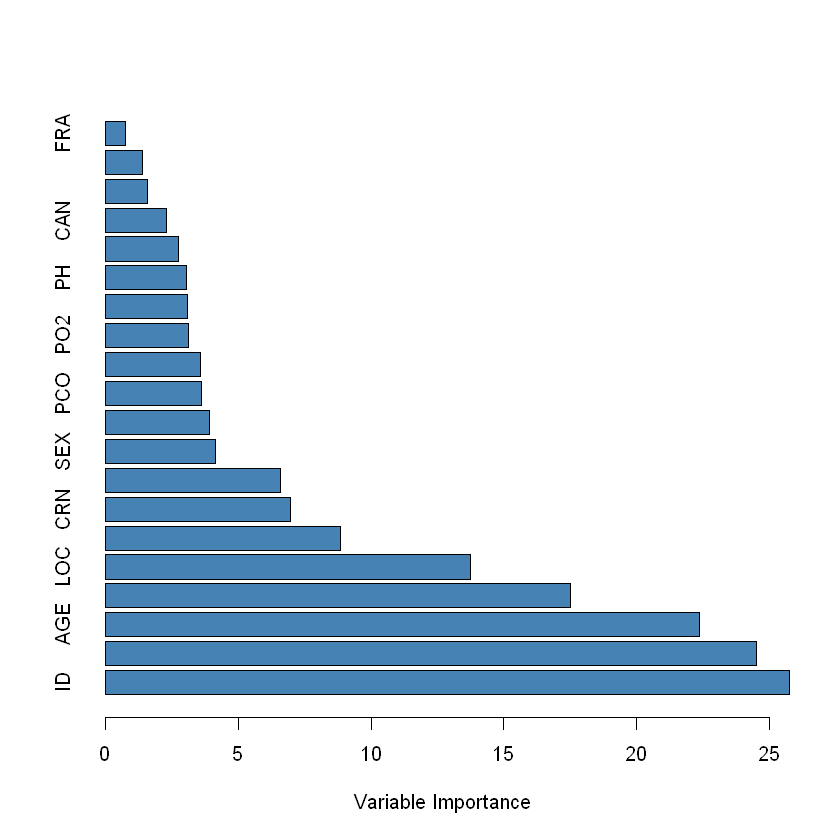

In [177]:
VI <- data.frame(var=names(icu[,-1]), imp=varImp(bag.fit))
VI_plot <- VI[order(VI$Overall, decreasing=TRUE),]
VI_plot
barplot(VI_plot$Overall,
        names.arg=rownames(VI_plot),
        horiz=TRUE,
        col='steelblue',
        xlab='Variable Importance')

In [178]:
set.seed(4)
icu <- icu[,c("STA", "SYS", "AGE", "ID", "HRA", "LOC", "TYP", "SER")]
sample <- sample(c(TRUE, FALSE), nrow(icu), replace=TRUE, prob=c(0.8,0.2))
train <- icu[sample, ]
test <- icu[!sample, ]

test.X <- test[2:8]
test.Y <- test[1]

train.X<-train[2:8]
train.Y<-train[1]

In [179]:
logit.fit <- glm(train$STA ~ ., data=train, family = binomial)

logit.train <- predict(logit.fit, train.X, type="response")
logit.train <- ifelse(test=logit.train>0.5, yes=1, no=0)

logit.pred <- predict(logit.fit, test.X, type="response")
logit.pred <- ifelse(test=logit.pred>0.5, yes=1, no=0)

message("Train Error is ", round(mean(logit.train != train.Y$STA),2)*100, "%")
message("Test Error is ", round(mean(logit.pred != test.Y$STA),2)*100, "%")

Train Error is 13%

Test Error is 9%



Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test.Y$STA, predictor = logit.pred, plot = TRUE)

Data: logit.pred in 40 controls (test.Y$STA 0) < 7 cases (test.Y$STA 1).
Area under the curve: 0.7732

Setting levels: control = 0, case = 1

Setting direction: controls < cases

AUC: 0.773214285714286



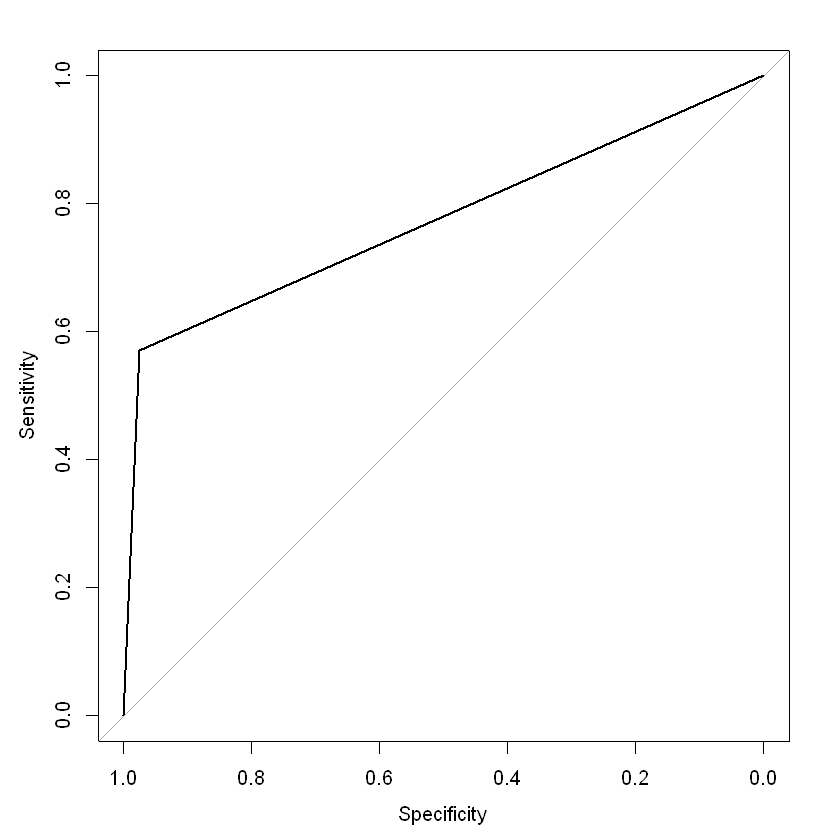

In [180]:
roc(test.Y$STA, logit.pred, plot=TRUE)
message("AUC: ", auc(test.Y$STA, logit.pred))

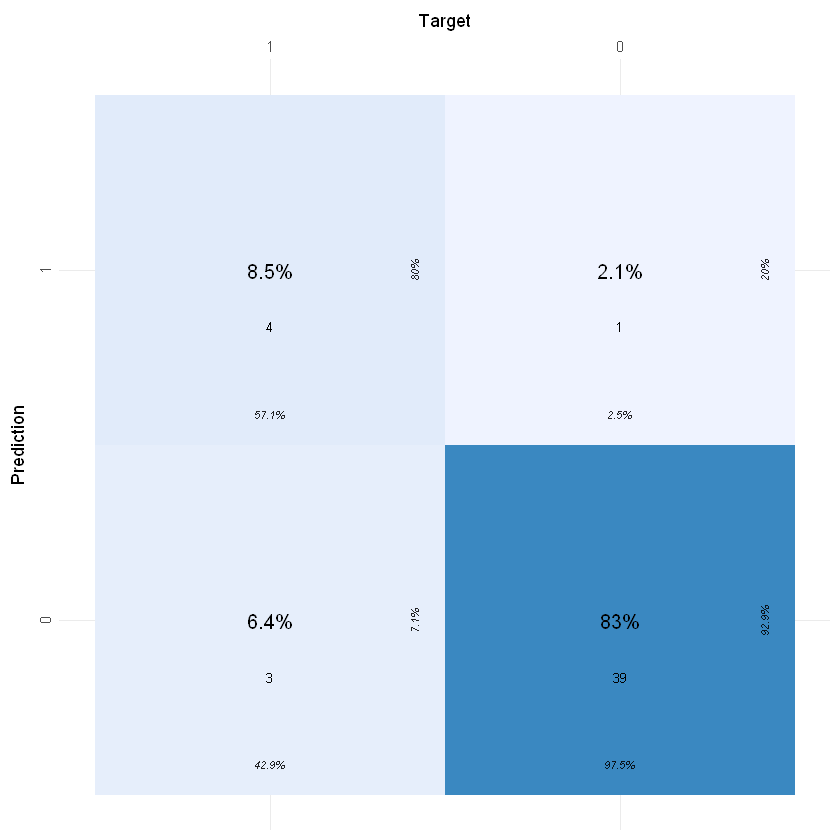

In [181]:
plot_confusion_matrix(confusion_matrix(test.Y$STA, logit.pred))

## Results

So in both cases we used bagging in order to find the most important features and prevent overfitting (before bagging, there was low training error, but high test error).